<a href="https://colab.research.google.com/github/Katerina197/lab01/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8228c2a4c5e4f59a67c0ad909bc23c0d241896b65749be4e29d7b541106b0b2b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/DSC511-project/data/ml-latest-small/"

Mounted at /content/gdrive


In [ ]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import countDistinct, col
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, split
from wordcloud import WordCloud

# create a spark session and import graphframes
spark = SparkSession.builder.appName("DSC511_project").getOrCreate()

In [ ]:
ratings = spark.read.csv(google_drive_path + 'ratings.csv', header=True, inferSchema=True)
ratings.printSchema()

tags = spark.read.csv(google_drive_path + 'tags.csv', header=True, inferSchema=True)
tags.printSchema()

movies = spark.read.csv(google_drive_path + 'movies.csv', header=True, inferSchema=True)
movies.printSchema()

links = spark.read.csv(google_drive_path + 'links.csv', header=True, inferSchema=True)
links.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



**Exploring Missing Values and Distinct Values in DataFrames**


In [ ]:
from pyspark.sql.functions import countDistinct, col

def compute_counts(df):
    # Create empty lists to store the results
    missing_counts = []
    distinct_counts = []

    # Iterate over each column in the DataFrame
    for col_name in df.columns:
        # Count the number of missing values (NA) in the column
        missing_count = df.filter(col(col_name).isNull()).count()
        missing_counts.append((col_name, missing_count))

        # Count the number of distinct values in the column
        distinct_count = df.select(countDistinct(col_name)).collect()[0][0]
        distinct_counts.append((col_name, distinct_count))

    # Return the results
    return missing_counts, distinct_counts

# Compute missing and distinct value counts for each DataFrame
ratings_missing_counts, ratings_distinct_counts = compute_counts(ratings)
tags_missing_counts, tags_distinct_counts = compute_counts(tags)
movies_missing_counts, movies_distinct_counts = compute_counts(movies)
links_missing_counts, links_distinct_counts = compute_counts(links)

# Display the results
print("Ratings DataFrame:")
print("Missing Value Counts:")
for col_name, count in ratings_missing_counts:
    print(f"{col_name}: {count}")
print("\nDistinct Value Counts:")
for col_name, count in ratings_distinct_counts:
    print(f"{col_name}: {count}")

# Display the results for tags_df
print("\nTags DataFrame:")
print("Missing Value Counts:")
for col_name, count in tags_missing_counts:
    print(f"{col_name}: {count}")
print("\nDistinct Value Counts:")
for col_name, count in tags_distinct_counts:
    print(f"{col_name}: {count}")

# Display the results for movies_df
print("\nMovies DataFrame:")
print("Missing Value Counts:")
for col_name, count in movies_missing_counts:
    print(f"{col_name}: {count}")
print("\nDistinct Value Counts:")
for col_name, count in movies_distinct_counts:
    print(f"{col_name}: {count}")

# Display results for links_df
print("\nLinks DataFrame:")
print("Missing Value Counts:")
for col_name, count in links_missing_counts:
    print(f"{col_name}: {count}")
print("\nDistinct Value Counts:")
for col_name, count in links_distinct_counts:
    print(f"{col_name}: {count}")

Ratings DataFrame:
Missing Value Counts:
userId: 0
movieId: 0
rating: 0
timestamp: 0

Distinct Value Counts:
userId: 610
movieId: 9724
rating: 10
timestamp: 85043

Tags DataFrame:
Missing Value Counts:
userId: 0
movieId: 0
tag: 0
timestamp: 0

Distinct Value Counts:
userId: 58
movieId: 1572
tag: 1589
timestamp: 3411

Movies DataFrame:
Missing Value Counts:
movieId: 0
title: 0
genres: 0

Distinct Value Counts:
movieId: 9742
title: 9737
genres: 951

Links DataFrame:
Missing Value Counts:
movieId: 0
imdbId: 0
tmdbId: 8

Distinct Value Counts:
movieId: 9742
imdbId: 9742
tmdbId: 9733


# **EXPLORATORY DATA ANALYSIS AND PREPROCESSING**

### Movies DataFrame

In [ ]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

Print the shape of the movie DataFrame

In [ ]:
num_rows = movies.count()
num_columns = len(movies.columns)

print(f"Shape: ({num_rows}, {num_columns})")

Shape: (9742, 3)


The following function extracts the release years from each title by identifying sequences of four consecutive numbers and creates a new column with the extracted years. It also removes the year from the title to provide a clean title column. Furthermore, it splits the genres and converts them into dummy variables to facilitate exploratory analysis.

In [ ]:
from pyspark.sql.functions import regexp_extract, col

def preprocess_movie_csv(movie_df):

    movie_df = movie_df.withColumn('release_year', regexp_extract(col('title'), '\((\d{4})\)', 1))
    movie_df = movie_df.withColumn('title', regexp_replace(col('title'), '\s?\(\d{4}\)', ''))
    genres = movie_df.select('genres').rdd.flatMap(lambda x: x[0].split('|')).distinct().collect()

    for genre in genres:
        movie_df = movie_df.withColumn(genre, col('genres').contains(genre))

    movie_df = movie_df.drop('genres')    # Drop the original genres column
    return movie_df

In [ ]:
processed_movies_df = preprocess_movie_csv(movies)
processed_movies_df = processed_movies_df.withColumnRenamed("(no genres listed)", "No_Genre")
processed_movies_df.show()

+-------+--------------------+------------+---------+---------+--------+------+-------+-------+-----+------+-----+--------+------+-------+------+-----+-------+-----------+-----+-------+---------+--------+
|movieId|               title|release_year|Adventure|Animation|Children|Comedy|Fantasy|Romance|Drama|Action|Crime|Thriller|Horror|Mystery|Sci-Fi|  War|Musical|Documentary| IMAX|Western|Film-Noir|No_Genre|
+-------+--------------------+------------+---------+---------+--------+------+-------+-------+-----+------+-----+--------+------+-------+------+-----+-------+-----------+-----+-------+---------+--------+
|      1|           Toy Story|        1995|     true|     true|    true|  true|   true|  false|false| false|false|   false| false|  false| false|false|  false|      false|false|  false|    false|   false|
|      2|             Jumanji|        1995|     true|    false|    true| false|   true|  false|false| false|false|   false| false|  false| false|false|  false|      false|false|  f

In [ ]:
num_rows = processed_movies_df.count()
num_columns = len(processed_movies_df.columns)
print(f"Shape: ({num_rows}, {num_columns})")

Shape: (9742, 23)


In [ ]:
df_movies_titles = processed_movies_df.select('movieId', 'title')
df_movies_titles.show()

+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|      1|           Toy Story|
|      2|             Jumanji|
|      3|    Grumpier Old Men|
|      4|   Waiting to Exhale|
|      5|Father of the Bri...|
|      6|                Heat|
|      7|             Sabrina|
|      8|        Tom and Huck|
|      9|        Sudden Death|
|     10|           GoldenEye|
|     11|American Presiden...|
|     12|Dracula: Dead and...|
|     13|               Balto|
|     14|               Nixon|
|     15|    Cutthroat Island|
|     16|              Casino|
|     17|Sense and Sensibi...|
|     18|          Four Rooms|
|     19|Ace Ventura: When...|
|     20|         Money Train|
+-------+--------------------+
only showing top 20 rows



The number of released movies for each year

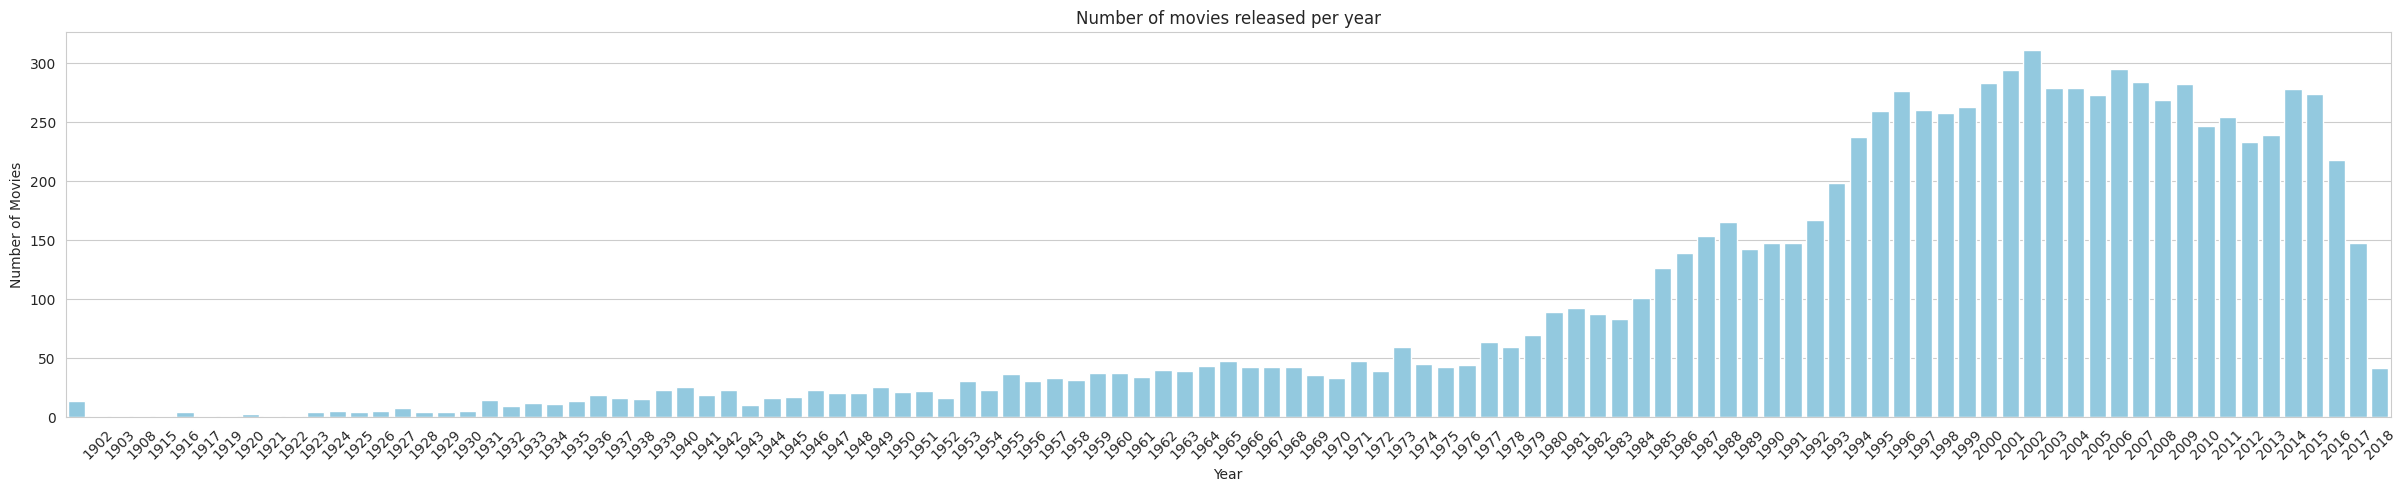

In [ ]:
df_temp = processed_movies_df.groupBy('release_year').count().orderBy('release_year')
df_temp_pd = df_temp.toPandas()   #convert to Pandas DataFrame

plt.figure(figsize=(30, 5))
sns.barplot(data=df_temp_pd, x='release_year', y='count', color='skyblue')
plt.title('Number of movies released per year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

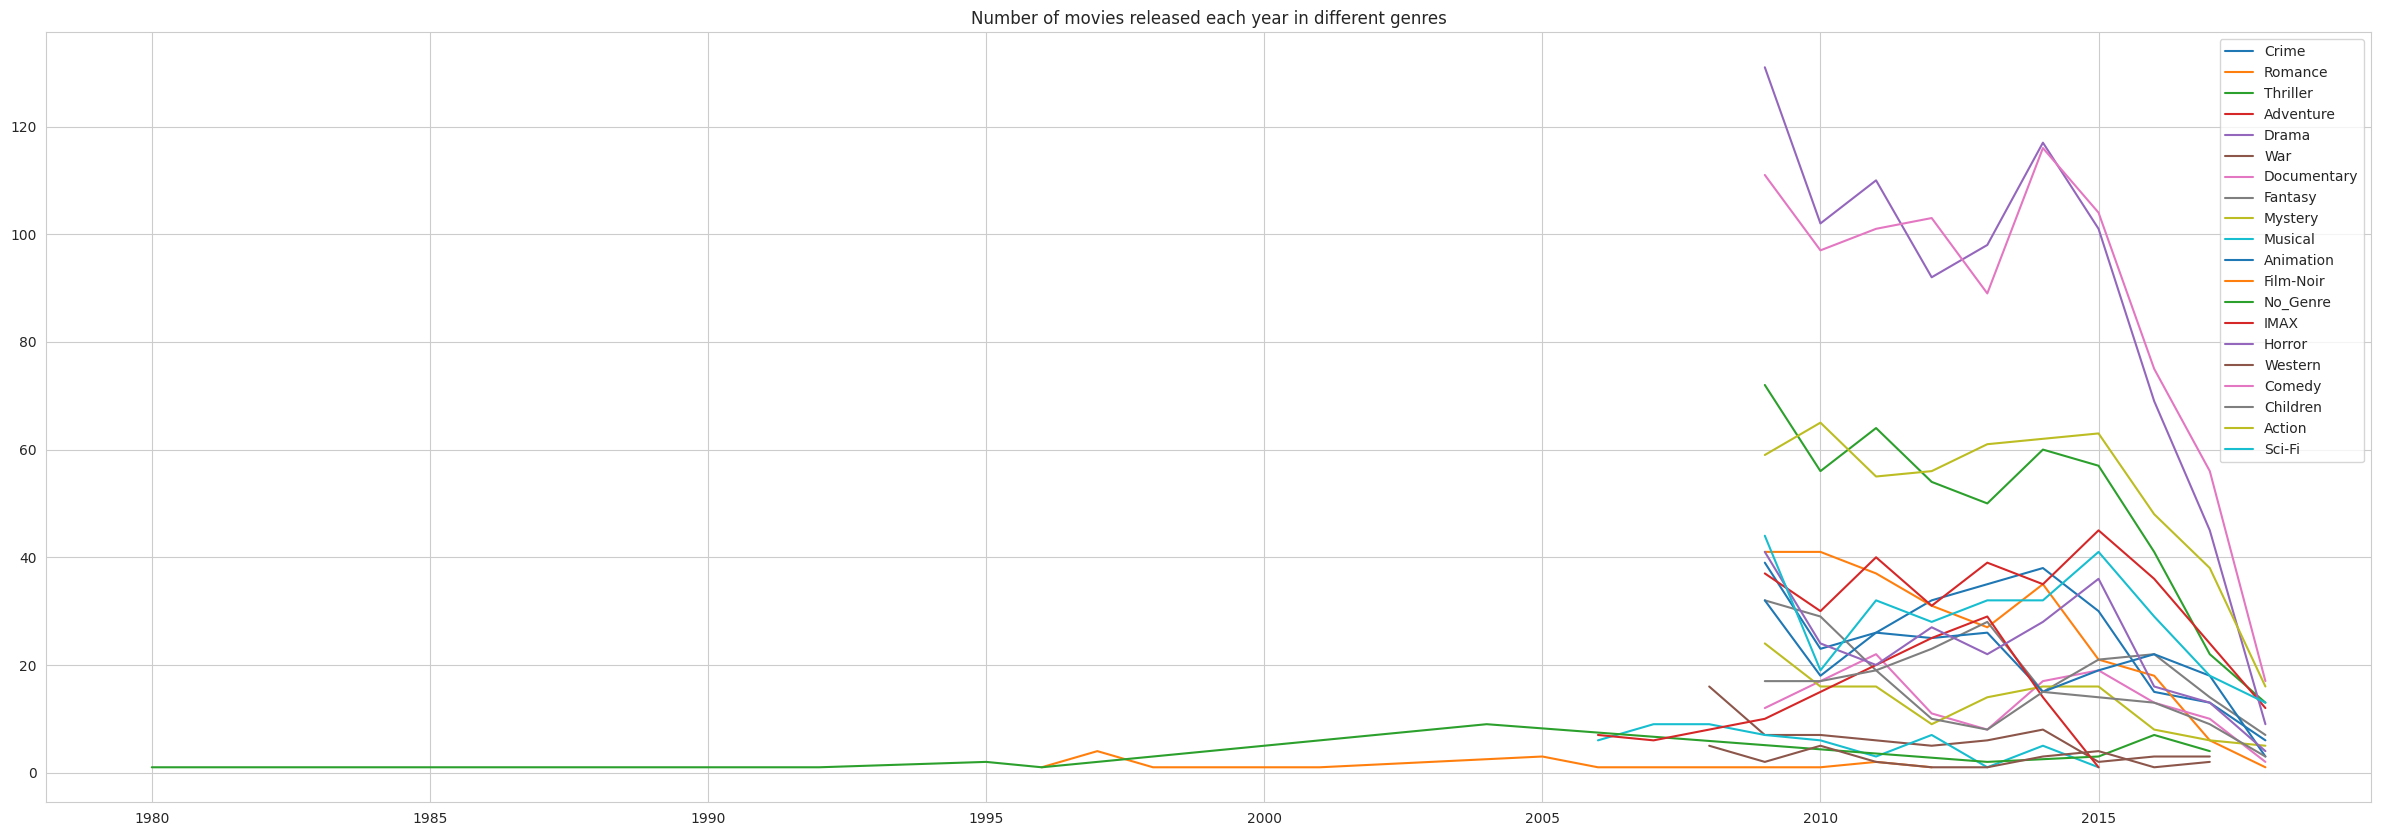

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import explode, split, col, when

# Get unique genres
genres_unique = (movies
                 .select(explode(split('genres', '\|')).alias('genre'))
                 .distinct()
                 .withColumn('genre', when(col('genre') != '(no genres listed)', col('genre')).otherwise('No_Genre'))
                 .toPandas())

# Initialize a figure
plt.figure(figsize=(30, 10))

# Iterate over each genre
for genre in genres_unique['genre']:
    # Filter DataFrame for the current genre
    df_temp = processed_movies_df.filter(col(genre)).select('release_year', 'movieId')

    # Fill NaN values in release_year with the mean of the years
    df_temp = df_temp.withColumn('release_year', df_temp['release_year'].cast('integer'))
    df_temp = df_temp.fillna({'release_year': df_temp.select(mean('release_year')).collect()[0][0]})

    # Group by release_year and count the number of movies for each year
    df_temp = (df_temp
               .groupBy('release_year')
               .count()
               .orderBy('release_year')
               .toPandas()
               .tail(10))  # Select the last 10 years for visualization

    # Plot the number of movies released each year for the current genre
    plt.plot(df_temp['release_year'], df_temp['count'], label=genre)

# Set plot title and legend
plt.title('Number of movies released each year in different genres')
plt.legend()

# Show the plot
plt.show()


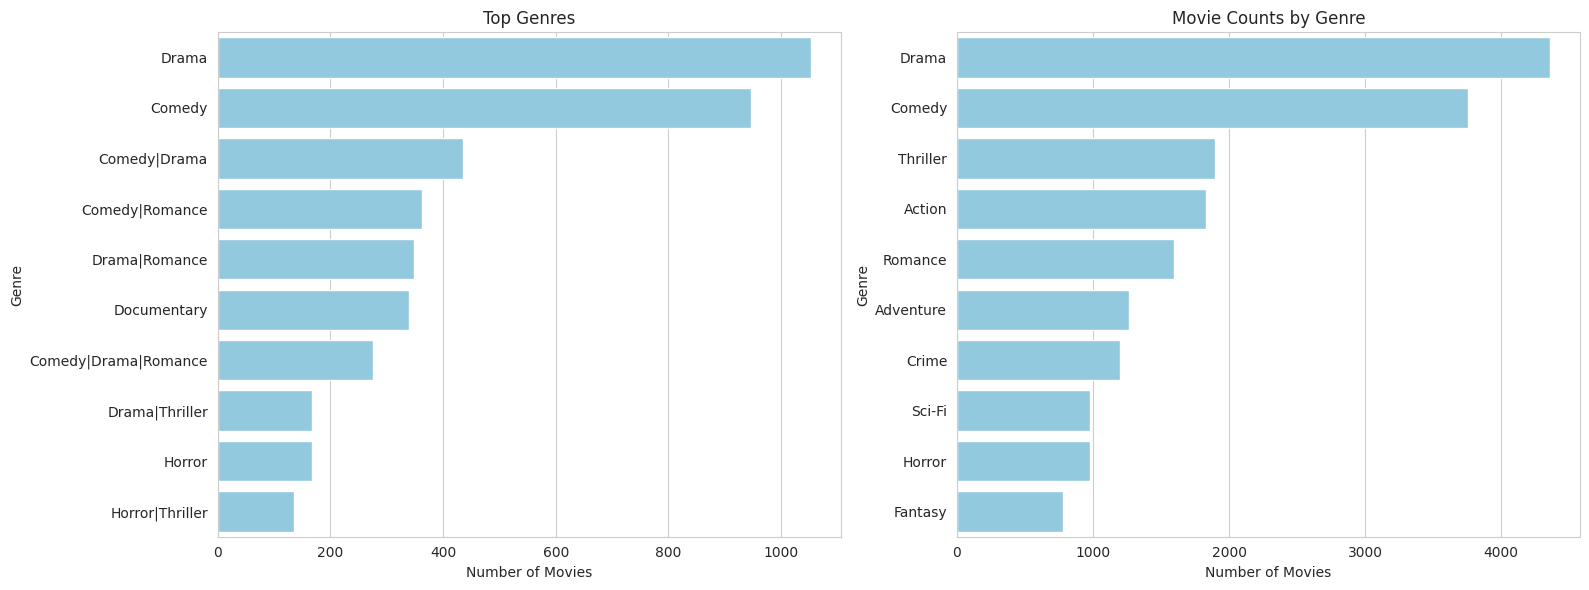

In [ ]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Changed to 1 row and 2 columns

# Top Genres
top_genres = movies.groupBy('genres').count().orderBy('count', ascending=False).toPandas()
top_genres = top_genres.head(10)  # Select top 10 genres for visualization
sns.barplot(data=top_genres, x='count', y='genres', color='skyblue', ax=axs[0])
axs[0].set_title('Top Genres')
axs[0].set_xlabel('Number of Movies')
axs[0].set_ylabel('Genre')

# Movie Counts by Genre
genres_counts = movies.select('movieId', 'genres') \
                         .withColumn('genre', explode(split('genres', '\|'))) \
                         .groupBy('genre').count().orderBy('count', ascending=False).toPandas()
sns.barplot(data=genres_counts.head(10), x='count', y='genre', color='skyblue', ax=axs[1])
axs[1].set_title('Movie Counts by Genre')
axs[1].set_xlabel('Number of Movies')
axs[1].set_ylabel('Genre')

plt.tight_layout()
plt.show()

Ratings DataFrame

In [ ]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
num_rows = ratings.count()
num_columns = len(ratings.columns)

print(f"Shape: ({num_rows}, {num_columns})")
print(f"Size: {num_rows * num_columns}")

Shape: (100836, 4)
Size: 403344


Convert timestamp column to a timestamp type by creating new columns

In [ ]:
from pyspark.sql.functions import year, month, to_date, to_timestamp

ratings = ratings.withColumn('timestamp', to_timestamp(ratings['timestamp']))

ratings = ratings.withColumn('year', year(ratings['timestamp'])) \
                     .withColumn('month', month(ratings['timestamp'])) \
                     .withColumn('date', to_date(ratings['timestamp']))

ratings = ratings.withColumn('time', ratings['timestamp'].cast('string').substr(12, 8))
ratings.show()

+------+-------+------+-------------------+----+-----+----------+--------+
|userId|movieId|rating|          timestamp|year|month|      date|    time|
+------+-------+------+-------------------+----+-----+----------+--------+
|     1|      1|   4.0|2000-07-30 18:45:03|2000|    7|2000-07-30|18:45:03|
|     1|      3|   4.0|2000-07-30 18:20:47|2000|    7|2000-07-30|18:20:47|
|     1|      6|   4.0|2000-07-30 18:37:04|2000|    7|2000-07-30|18:37:04|
|     1|     47|   5.0|2000-07-30 19:03:35|2000|    7|2000-07-30|19:03:35|
|     1|     50|   5.0|2000-07-30 18:48:51|2000|    7|2000-07-30|18:48:51|
|     1|     70|   3.0|2000-07-30 18:40:00|2000|    7|2000-07-30|18:40:00|
|     1|    101|   5.0|2000-07-30 18:14:28|2000|    7|2000-07-30|18:14:28|
|     1|    110|   4.0|2000-07-30 18:36:16|2000|    7|2000-07-30|18:36:16|
|     1|    151|   5.0|2000-07-30 19:07:21|2000|    7|2000-07-30|19:07:21|
|     1|    157|   5.0|2000-07-30 19:08:20|2000|    7|2000-07-30|19:08:20|
|     1|    163|   5.0|20

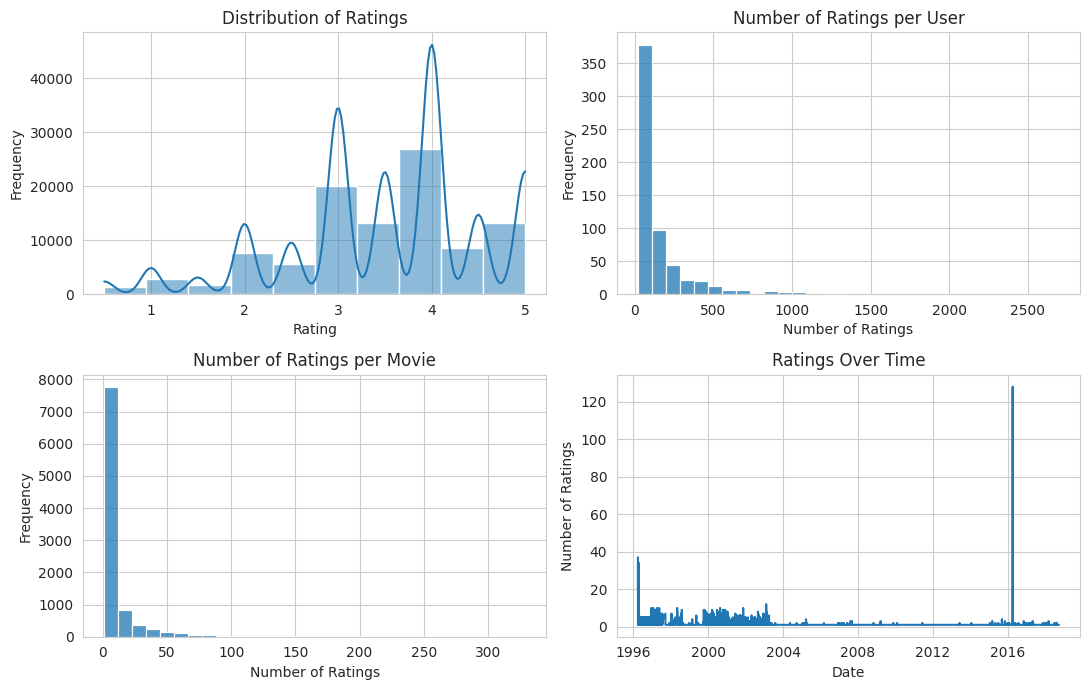

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(11, 7))

# Distribution of Ratings
sns.histplot(data=ratings.toPandas(), x='rating', bins=10, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Ratings')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Frequency')

# Number of Ratings per User
ratings_per_user = ratings.groupBy('userId').count().orderBy('count', ascending=False).toPandas()
sns.histplot(data=ratings_per_user, x='count', bins=30, ax=axs[0, 1])
axs[0, 1].set_title('Number of Ratings per User')
axs[0, 1].set_xlabel('Number of Ratings')
axs[0, 1].set_ylabel('Frequency')

# Number of Ratings per Movie
ratings_per_movie = ratings.groupBy('movieId').count().orderBy('count', ascending=False).toPandas()
sns.histplot(data=ratings_per_movie, x='count', bins=30, ax=axs[1, 0])
axs[1, 0].set_title('Number of Ratings per Movie')
axs[1, 0].set_xlabel('Number of Ratings')
axs[1, 0].set_ylabel('Frequency')

# Ratings Over Time
ratings_over_time = ratings.groupBy('timestamp').count().orderBy('timestamp').toPandas()
ratings_over_time['timestamp'] = pd.to_datetime(ratings_over_time['timestamp'], unit='s')
sns.lineplot(data=ratings_over_time, x='timestamp', y='count',ax=axs[1, 1])
axs[1, 1].set_title('Ratings Over Time')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Number of Ratings')

plt.tight_layout()
plt.show()

In [ ]:
ratings.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



Tags DataFframe

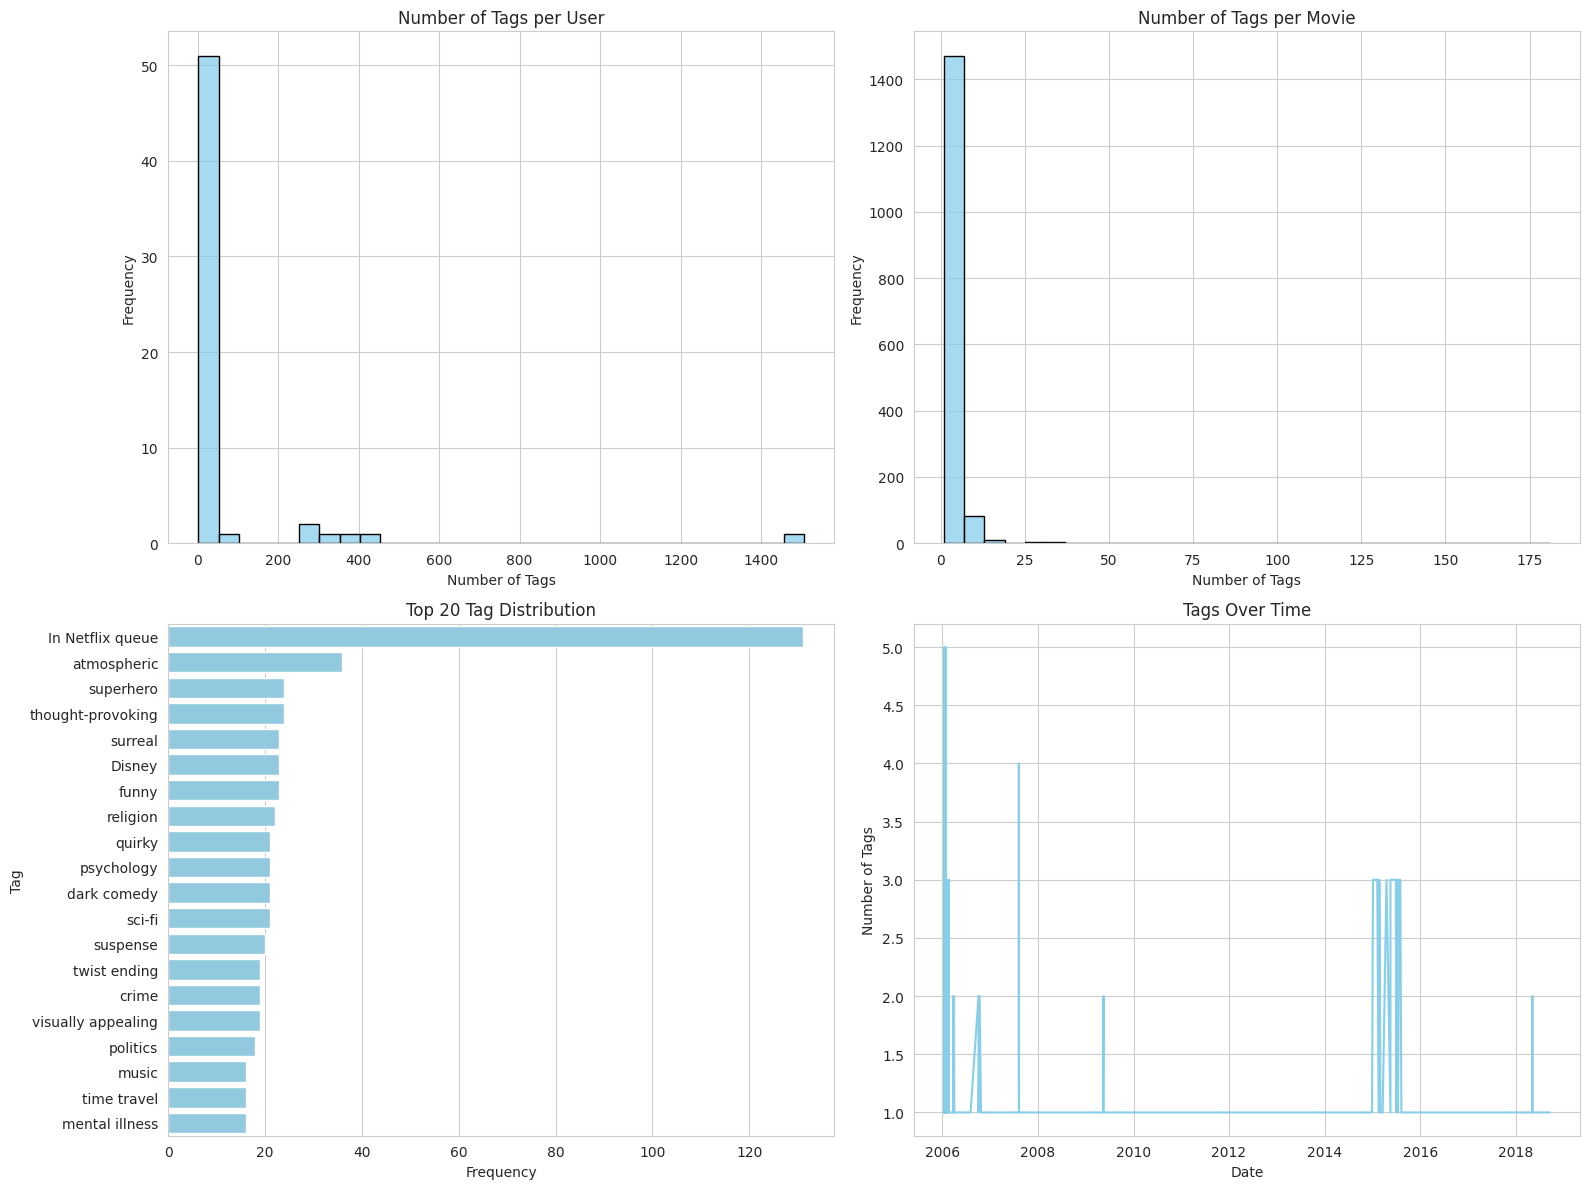

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Number of Tags per User
tags_per_user = tags.groupBy('userId').count().orderBy('count', ascending=False).toPandas()
sns.histplot(data=tags_per_user, x='count', bins=30, color='skyblue', edgecolor='black', ax=axs[0, 0])
axs[0, 0].set_title('Number of Tags per User')
axs[0, 0].set_xlabel('Number of Tags')
axs[0, 0].set_ylabel('Frequency')

# Number of Tags per Movie
tags_per_movie = tags.groupBy('movieId').count().orderBy('count', ascending=False).toPandas()
sns.histplot(data=tags_per_movie, x='count', bins=30, color='skyblue', edgecolor='black', ax=axs[0, 1])
axs[0, 1].set_title('Number of Tags per Movie')
axs[0, 1].set_xlabel('Number of Tags')
axs[0, 1].set_ylabel('Frequency')

# Distribution of Tags
plt.sca(axs[1, 0])
tags_distribution = tags.groupBy('tag').count().orderBy('count', ascending=False).toPandas()
sns.barplot(data=tags_distribution.head(20), x='count', y='tag', color='skyblue')
plt.title('Top 20 Tag Distribution')
plt.xlabel('Frequency')
plt.ylabel('Tag')

# Tags Over Time (assuming timestamp is in seconds)
plt.sca(axs[1, 1])
tags_over_time = tags.groupBy('timestamp').count().orderBy('timestamp').toPandas()
tags_over_time['timestamp'] = pd.to_datetime(tags_over_time['timestamp'], unit='s')
sns.lineplot(data=tags_over_time, x='timestamp', y='count', color='skyblue')
plt.title('Tags Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tags')


plt.tight_layout()
plt.show()

Links DataFrame

In [ ]:
links.show()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



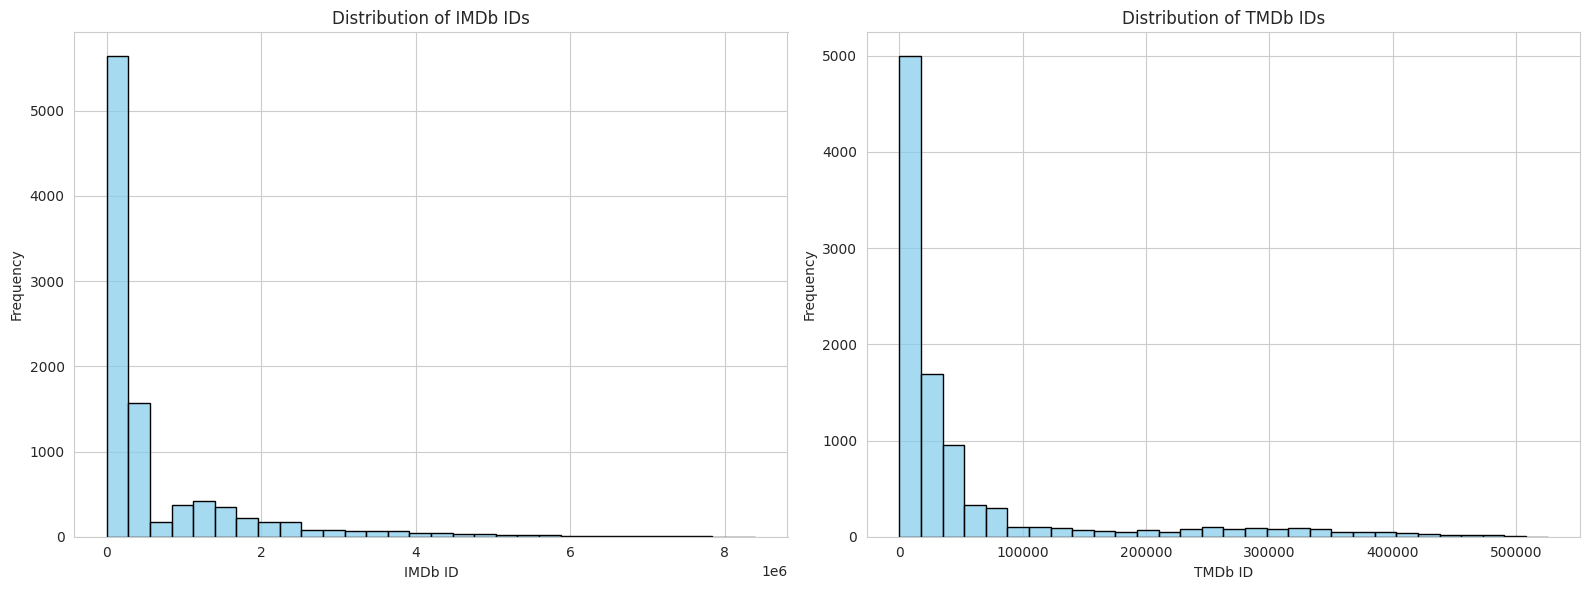

In [ ]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of IMDb IDs
sns.histplot(data=links.toPandas(), x='imdbId', bins=30, color='skyblue', edgecolor='black', ax=axs[0])
axs[0].set_title('Distribution of IMDb IDs')
axs[0].set_xlabel('IMDb ID')
axs[0].set_ylabel('Frequency')

# Distribution of TMDb IDs
sns.histplot(data=links.toPandas(), x='tmdbId', bins=30, color='skyblue', edgecolor='black', ax=axs[1])
axs[1].set_title('Distribution of TMDb IDs')
axs[1].set_xlabel('TMDb ID')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from pyspark.sql.functions import from_unixtime

df = tagsthColumn('timestamp_datetime', from_unixtime('timestamp'))
df.show()

+------+-------+-----------------+----------+-------------------+
|userId|movieId|              tag| timestamp| timestamp_datetime|
+------+-------+-----------------+----------+-------------------+
|     2|  60756|            funny|1445714994|2015-10-24 19:29:54|
|     2|  60756|  Highly quotable|1445714996|2015-10-24 19:29:56|
|     2|  60756|     will ferrell|1445714992|2015-10-24 19:29:52|
|     2|  89774|     Boxing story|1445715207|2015-10-24 19:33:27|
|     2|  89774|              MMA|1445715200|2015-10-24 19:33:20|
|     2|  89774|        Tom Hardy|1445715205|2015-10-24 19:33:25|
|     2| 106782|            drugs|1445715054|2015-10-24 19:30:54|
|     2| 106782|Leonardo DiCaprio|1445715051|2015-10-24 19:30:51|
|     2| 106782|  Martin Scorsese|1445715056|2015-10-24 19:30:56|
|     7|  48516|     way too long|1169687325|2007-01-25 01:08:45|
|    18|    431|        Al Pacino|1462138765|2016-05-01 21:39:25|
|    18|    431|         gangster|1462138749|2016-05-01 21:39:09|
|    18|  

In [ ]:
from pyspark.sql.functions import year

# Extract year from timestamp_datetime
df = df.withColumn('year', year('timestamp_datetime'))
df = df.withColumn('month', month('timestamp_datetime'))
df = df.withColumn('day', dayofmonth('timestamp_datetime'))
df = df.withColumn('hour', hour('timestamp_datetime'))
df = df.withColumn('minute', minute('timestamp_datetime'))
df = df.withColumn('second', second('timestamp_datetime'))
df.show()

+------+-------+-----------------+----------+-------------------+----+---+-----+----+------+------+
|userId|movieId|              tag| timestamp| timestamp_datetime|year|day|month|hour|minute|second|
+------+-------+-----------------+----------+-------------------+----+---+-----+----+------+------+
|     2|  60756|            funny|1445714994|2015-10-24 19:29:54|2015| 24|   10|  19|    29|    54|
|     2|  60756|  Highly quotable|1445714996|2015-10-24 19:29:56|2015| 24|   10|  19|    29|    56|
|     2|  60756|     will ferrell|1445714992|2015-10-24 19:29:52|2015| 24|   10|  19|    29|    52|
|     2|  89774|     Boxing story|1445715207|2015-10-24 19:33:27|2015| 24|   10|  19|    33|    27|
|     2|  89774|              MMA|1445715200|2015-10-24 19:33:20|2015| 24|   10|  19|    33|    20|
|     2|  89774|        Tom Hardy|1445715205|2015-10-24 19:33:25|2015| 24|   10|  19|    33|    25|
|     2| 106782|            drugs|1445715054|2015-10-24 19:30:54|2015| 24|   10|  19|    30|    54|
